In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from xgboost import plot_importance, XGBClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from time import time
import umap
import seaborn as sns

In [2]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [35]:
X = np.stack((X, X, X), axis=3)

In [36]:
X.shape

(2062, 64, 64, 3)

### Modèle de convolution avec Keras

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=42)

In [38]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1443, 64, 64, 3)
(619, 64, 64, 3)
(1443, 10)
(619, 10)


In [ ]:
X_train = X_train.reshape((1443, 64, 64, -1))
X_valid = X_valid.reshape((619, 64, 64, -1))
print(X_train.shape)
print(y_train.shape)

In [39]:
from keras.applications.vgg16 import VGG16
vgg_base = VGG16(weights="imagenet", include_top=False, classes=10, input_shape=(64,64,3))
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [48]:
import keras
from keras.optimizers import SGD
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(8192, activation='elu'))
model.add(Dropout(0.8))
model.add(Dense(4096, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [49]:
sgd = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
#checkpoint = keras.callbacks.ModelCheckpoint("Weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [50]:
history = model.fit(X_train/255.0, y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_valid/255.0,y_valid/255.0), shuffle=True)

Train on 1443 samples, validate on 619 samples
Epoch 1/15
1443/1443 [==============================] - 176s 122ms/step - loss: 14.5431 - accuracy: 0.0977 - val_loss: 0.0566 - val_accuracy: 0.1050
Epoch 2/15
1443/1443 [==============================] - 179s 124ms/step - loss: 14.5096 - accuracy: 0.0998 - val_loss: 0.0566 - val_accuracy: 0.1050
Epoch 3/15
1443/1443 [==============================] - 179s 124ms/step - loss: 14.4650 - accuracy: 0.1026 - val_loss: 0.0566 - val_accuracy: 0.1050
Epoch 4/15
1443/1443 [==============================] - 180s 124ms/step - loss: 14.5096 - accuracy: 0.0998 - val_loss: 0.0566 - val_accuracy: 0.1050
Epoch 5/15
1443/1443 [==============================] - 180s 125ms/step - loss: 14.5990 - accuracy: 0.0942 - val_loss: 0.0566 - val_accuracy: 0.1050
Epoch 6/15
1443/1443 [==============================] - 194s 135ms/step - loss: 14.3868 - accuracy: 0.1074 - val_loss: 0.0566 - val_accuracy: 0.1050
Epoch 7/15
1443/1443 [==============================] - 226

KeyboardInterrupt: 

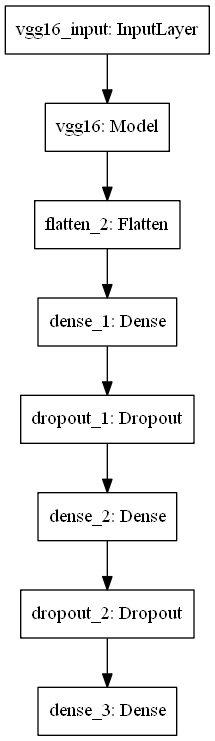

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='vgg.png')

In [8]:
image = X[2]
image = np.pad(image, pad_width=80, mode='constant', constant_values=0)

In [9]:
image.shape

(224, 224)

In [10]:
image = np.dstack((image, image, image))

In [11]:
image.shape

(224, 224, 3)

In [12]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [13]:
image.shape

(1, 224, 224, 3)

In [14]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [15]:
# predict the probability across all output classes
yhat = model.predict(image)

In [16]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 10)

In [ ]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('../images/mug.jpg', target_size=(224, 224))

In [ ]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

In [ ]:
image.shape

In [ ]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [ ]:
image.shape

In [ ]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [ ]:
# predict the probability across all output classes
yhat = model.predict(image)

In [ ]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
accuracy = accuracy_score(y_valid_flat, Y_predict)
print(accuracy)

In [ ]:
predict_ok = []
true = 0
false = 0
for i in range(len(Y_predict)):
    if Y_predict[i] == y_valid_flat[i]:
        p = True 
        true += 1    
    else:
        p = False
        false += 1
    predict_ok.append(p)
                
predict_ok
print('Nombres de prédictions Valide :',true)
print('Nombres de mauvaise prédictions :',false)

In [ ]:
df = pd.DataFrame(conf_mat, range(10),
                  range(10))
df.rename_axis('Prédites').rename_axis('Réelles', axis='columns')